# Phase 3: Model & Strategy Comparison - Evasion Label
This phase compares different classifiers (Logistic Regression, SVM, Naive Bayes) and tests the hypothesis of grouped vs. all classes for **evasion_label**.

## Imports & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import os

from src.preprocessing import get_preprocessed_data

SEED = 42
np.random.seed(SEED)

# Create directories
os.makedirs('figures', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Load data
train_df, val_df, test_df, id2label, label2id = get_preprocessed_data()

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
print(f"\nEvasion label distribution:")
print(train_df['evasion_label'].value_counts())

Train: 2758, Val: 690, Test: 308

Evasion label distribution:
evasion_label
5    841
4    565
7    390
6    309
3    305
2    116
0     95
1     74
8     63
Name: count, dtype: int64


## Helper Functions for Grouping Labels

In [2]:
def group_evasion_labels(series, id2label):
    """
    Group evasion labels into 3 main classes:
    - Clear Reply: Explicit
    - Ambivalent Reply: General, Implicit, Dodging, Deflection, Partial/half-answer
    - Clear non-reply: Claims ignorance, Clarification, Declining to answer
    """
    # First convert integers back to string labels
    string_labels = series.map(id2label)
    
    # Then apply grouping mapping
    mapping = {
        'Explicit': 'Clear Reply',
        'General': 'Ambivalent Reply',
        'Implicit': 'Ambivalent Reply',
        'Dodging': 'Ambivalent Reply',
        'Claims ignorance': 'Clear non-reply',
        'Clarification': 'Clear non-reply',
        'Declining to answer': 'Clear non-reply',
        'Partial/half-answer': 'Ambivalent Reply',
        'Deflection': 'Ambivalent Reply',
    }
    return string_labels.map(mapping)

# Create grouped versions
for df in [train_df, val_df, test_df]:
    df['evasion_label_grouped'] = group_evasion_labels(df['evasion_label'], id2label)

print("Evasion label distribution (all classes):")
print(train_df['evasion_label'].value_counts())
print("\nEvasion label distribution (grouped):")
print(train_df['evasion_label_grouped'].value_counts())

Evasion label distribution (all classes):
evasion_label
5    841
4    565
7    390
6    309
3    305
2    116
0     95
1     74
8     63
Name: count, dtype: int64

Evasion label distribution (grouped):
evasion_label_grouped
Ambivalent Reply    1632
Clear Reply          841
Clear non-reply      285
Name: count, dtype: int64


## Prepare Best Features from Phase 2
Based on Phase 2 results, we use:
- Sub-question + Answer context
- Meta-features (multiple_questions, affirmative_questions, inaudible)
- Trigrams (1, 3) which performed best

In [3]:
# Create contextual features
for df in [train_df, val_df, test_df]:
    df['sub_q_context'] = df['question'].fillna('') + " [SEP] " + df['interview_answer'].fillna('')
    
meta_cols = ['multiple_questions', 'affirmative_questions', 'inaudible']
for df in [train_df, val_df, test_df]:
    for col in meta_cols:
        df[col] = df[col].astype(int)

print("Features prepared!")
print(f"Text feature: sub_q_context")
print(f"Meta features: {meta_cols}")

Features prepared!
Text feature: sub_q_context
Meta features: ['multiple_questions', 'affirmative_questions', 'inaudible']


## Experiment Runner Function

In [7]:
def run_classifier_experiment(
    clf_name,
    vectorizer_name,
    use_grouped,
    train_df,
    val_df,
    use_meta_features=True,
    ngram_range=(1, 2)
):
    """
    Run a single classifier experiment on evasion_label
    
    Parameters:
    - clf_name: 'logistic', 'svm', or 'naive_bayes'
    - vectorizer_name: 'tfidf' or 'count'
    - use_grouped: True for 3 classes, False for all 7 classes
    - use_meta_features: whether to include meta-features
    - ngram_range: tuple for n-gram range
    """
    
    # Get labels
    label_column = 'evasion_label_grouped' if use_grouped else 'evasion_label'
    y_train = train_df[label_column]
    y_val = val_df[label_column]
    
    # Build vectorizer
    vec_params = {
        'max_features': 2000,
        'ngram_range': ngram_range,
        'min_df': 2,
        'max_df': 0.95
    }
    
    if vectorizer_name == 'tfidf':
        vectorizer = TfidfVectorizer(**vec_params)
    else:  # count
        vectorizer = CountVectorizer(**vec_params)
    
    # Build classifier
    if clf_name == 'logistic':
        classifier = LogisticRegression(max_iter=1000, multi_class="multinomial", random_state=SEED)
    elif clf_name == 'svm':
        classifier = LinearSVC(max_iter=2000, multi_class="ovr", random_state=SEED, dual='auto')
    else:  # naive_bayes
        classifier = MultinomialNB()
    
    # Build pipeline
    if use_meta_features:
        preprocessor = ColumnTransformer(
            transformers=[
                ('text', vectorizer, 'sub_q_context'),
                ('meta', 'passthrough', meta_cols)
            ]
        )
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])
        X_train = train_df
        X_val = val_df
    else:
        X_train_text = train_df['sub_q_context']
        X_val_text = val_df['sub_q_context']
        X_train = vectorizer.fit_transform(X_train_text)
        X_val = vectorizer.transform(X_val_text)
        pipeline = classifier
    
    # Train
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_val)
    
    # Calculate metrics
    metrics = {
        'classifier': clf_name,
        'vectorizer': vectorizer_name,
        'classes': 'grouped_3' if use_grouped else 'all_7',
        'use_meta': use_meta_features,
        'f1_macro': f1_score(y_val, y_pred, average='macro', zero_division=0),
        'f1_weighted': f1_score(y_val, y_pred, average='weighted', zero_division=0),
        'precision': precision_score(y_val, y_pred, average='macro', zero_division=0),
        'recall': recall_score(y_val, y_pred, average='macro', zero_division=0),
        'accuracy': accuracy_score(y_val, y_pred)
    }
    
    return metrics, pipeline, y_pred, y_val

print("Experiment runner ready!")

Experiment runner ready!


## Experiment 1: Classifier Comparison (All 7 Classes)

In [5]:
results_all_classes = []

classifiers = ['logistic', 'svm', 'naive_bayes']
vectorizers = ['tfidf', 'count']

print("\n" + "="*80)
print("EXPERIMENT 1: Classifier Comparison - All 7 Evasion Classes")
print("="*80)

for clf_name in classifiers:
    for vec_name in vectorizers:
        print(f"\nTesting: {clf_name} + {vec_name}...")
        
        metrics, _, _, _ = run_classifier_experiment(
            clf_name=clf_name,
            vectorizer_name=vec_name,
            use_grouped=False,  # All 7 classes
            train_df=train_df,
            val_df=val_df,
            use_meta_features=True
        )
        
        results_all_classes.append(metrics)
        print(f"  F1 Macro:    {metrics['f1_macro']:.4f}")
        print(f"  F1 Weighted: {metrics['f1_weighted']:.4f}")
        print(f"  Accuracy:    {metrics['accuracy']:.4f}")

df_all_classes = pd.DataFrame(results_all_classes)
df_all_sorted = df_all_classes.sort_values('f1_macro', ascending=False)

print("\n" + "="*80)
print("RESULTS SUMMARY - All 7 Classes")
print("="*80)
print(df_all_sorted[['classifier', 'vectorizer', 'f1_macro', 'f1_weighted', 'accuracy']].to_string(index=False))


EXPERIMENT 1: Classifier Comparison - All 7 Evasion Classes

Testing: logistic + tfidf...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  F1 Macro:    0.1748
  F1 Weighted: 0.2831
  Accuracy:    0.3522

Testing: logistic + count...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  F1 Macro:    0.2896
  F1 Weighted: 0.3171
  Accuracy:    0.3188

Testing: svm + tfidf...
  F1 Macro:    0.2704
  F1 Weighted: 0.3151
  Accuracy:    0.3246

Testing: svm + count...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  F1 Macro:    0.2612
  F1 Weighted: 0.3031
  Accuracy:    0.3043

Testing: naive_bayes + tfidf...
  F1 Macro:    0.0859
  F1 Weighted: 0.1995
  Accuracy:    0.3275

Testing: naive_bayes + count...
  F1 Macro:    0.2375
  F1 Weighted: 0.2961
  Accuracy:    0.2942

RESULTS SUMMARY - All 7 Classes
 classifier vectorizer  f1_macro  f1_weighted  accuracy
   logistic      count  0.289604     0.317115  0.318841
        svm      tfidf  0.270441     0.315089  0.324638
        svm      count  0.261238     0.303085  0.304348
naive_bayes      count  0.237520     0.296076  0.294203
   logistic      tfidf  0.174766     0.283083  0.352174
naive_bayes      tfidf  0.085863     0.199457  0.327536


## Experiment 2: Classifier Comparison (Grouped 3 Classes)

In [8]:
results_grouped = []

print("\n" + "="*80)
print("EXPERIMENT 2: Classifier Comparison - Grouped 3 Classes")
print("="*80)

for clf_name in classifiers:
    for vec_name in vectorizers:
        print(f"\nTesting: {clf_name} + {vec_name}...")
        
        metrics, _, _, _ = run_classifier_experiment(
            clf_name=clf_name,
            vectorizer_name=vec_name,
            use_grouped=True,  # Grouped 3 classes
            train_df=train_df,
            val_df=val_df,
            use_meta_features=True
        )
        
        results_grouped.append(metrics)
        print(f"  F1 Macro:    {metrics['f1_macro']:.4f}")
        print(f"  F1 Weighted: {metrics['f1_weighted']:.4f}")
        print(f"  Accuracy:    {metrics['accuracy']:.4f}")

df_grouped = pd.DataFrame(results_grouped)
df_grouped_sorted = df_grouped.sort_values('f1_macro', ascending=False)

print("\n" + "="*80)
print("RESULTS SUMMARY - Grouped 3 Classes")
print("="*80)
print(df_grouped_sorted[['classifier', 'vectorizer', 'f1_macro', 'f1_weighted', 'accuracy']].to_string(index=False))


EXPERIMENT 2: Classifier Comparison - Grouped 3 Classes

Testing: logistic + tfidf...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  F1 Macro:    0.4311
  F1 Weighted: 0.5595
  Accuracy:    0.6174

Testing: logistic + count...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  F1 Macro:    0.4843
  F1 Weighted: 0.5592
  Accuracy:    0.5638

Testing: svm + tfidf...
  F1 Macro:    0.4941
  F1 Weighted: 0.5782
  Accuracy:    0.5971

Testing: svm + count...
  F1 Macro:    0.4837
  F1 Weighted: 0.5562
  Accuracy:    0.5551

Testing: naive_bayes + tfidf...
  F1 Macro:    0.2777
  F1 Weighted: 0.4661
  Accuracy:    0.5913

Testing: naive_bayes + count...
  F1 Macro:    0.4906
  F1 Weighted: 0.5469
  Accuracy:    0.5377

RESULTS SUMMARY - Grouped 3 Classes
 classifier vectorizer  f1_macro  f1_weighted  accuracy
        svm      tfidf  0.494090     0.578236  0.597101
naive_bayes      count  0.490591     0.546873  0.537681
   logistic      count  0.484260     0.559170  0.563768
        svm      count  0.483674     0.556193  0.555072
   logistic      tfidf  0.431109     0.559499  0.617391
naive_bayes      tfidf  0.277734     0.466061  0.591304


## Experiment 3: Direct Comparison - Grouped vs. All Classes

In [9]:
comparison_data = []

print("\n" + "="*80)
print("EXPERIMENT 3: Grouped (3) vs. All (7) Classes - Direct Comparison")
print("="*80)

for clf_name in classifiers:
    for vec_name in vectorizers:
        model_name = f"{clf_name} + {vec_name}"
        print(f"\n{model_name}:")
        
        # Get F1 scores from previous experiments
        f1_all = df_all_classes[
            (df_all_classes['classifier'] == clf_name) & 
            (df_all_classes['vectorizer'] == vec_name)
        ]['f1_macro'].values[0]
        
        f1_grouped = df_grouped[
            (df_grouped['classifier'] == clf_name) & 
            (df_grouped['vectorizer'] == vec_name)
        ]['f1_macro'].values[0]
        
        improvement = f1_grouped - f1_all
        improvement_pct = (improvement / f1_all) * 100 if f1_all > 0 else 0
        
        print(f"  All 7 classes:  F1 = {f1_all:.4f}")
        print(f"  Grouped 3:      F1 = {f1_grouped:.4f}")
        print(f"  Improvement:    {improvement:+.4f} ({improvement_pct:+.1f}%)")
        
        comparison_data.append({
            'model': model_name,
            'classifier': clf_name,
            'vectorizer': vec_name,
            'f1_all_7': f1_all,
            'f1_grouped_3': f1_grouped,
            'improvement': improvement,
            'improvement_pct': improvement_pct
        })

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("COMPARISON SUMMARY")
print("="*80)
print(df_comparison[['model', 'f1_all_7', 'f1_grouped_3', 'improvement', 'improvement_pct']].to_string(index=False))

# Calculate average improvement
avg_improvement = df_comparison['improvement'].mean()
print(f"\nAverage improvement from grouping: {avg_improvement:+.4f}")


EXPERIMENT 3: Grouped (3) vs. All (7) Classes - Direct Comparison

logistic + tfidf:
  All 7 classes:  F1 = 0.1748
  Grouped 3:      F1 = 0.4311
  Improvement:    +0.2563 (+146.7%)

logistic + count:
  All 7 classes:  F1 = 0.2896
  Grouped 3:      F1 = 0.4843
  Improvement:    +0.1947 (+67.2%)

svm + tfidf:
  All 7 classes:  F1 = 0.2704
  Grouped 3:      F1 = 0.4941
  Improvement:    +0.2236 (+82.7%)

svm + count:
  All 7 classes:  F1 = 0.2612
  Grouped 3:      F1 = 0.4837
  Improvement:    +0.2224 (+85.1%)

naive_bayes + tfidf:
  All 7 classes:  F1 = 0.0859
  Grouped 3:      F1 = 0.2777
  Improvement:    +0.1919 (+223.5%)

naive_bayes + count:
  All 7 classes:  F1 = 0.2375
  Grouped 3:      F1 = 0.4906
  Improvement:    +0.2531 (+106.5%)

COMPARISON SUMMARY
              model  f1_all_7  f1_grouped_3  improvement  improvement_pct
   logistic + tfidf  0.174766      0.431109     0.256343       146.678288
   logistic + count  0.289604      0.484260     0.194656        67.214724
        

## Visualization: Grouped vs. All Classes

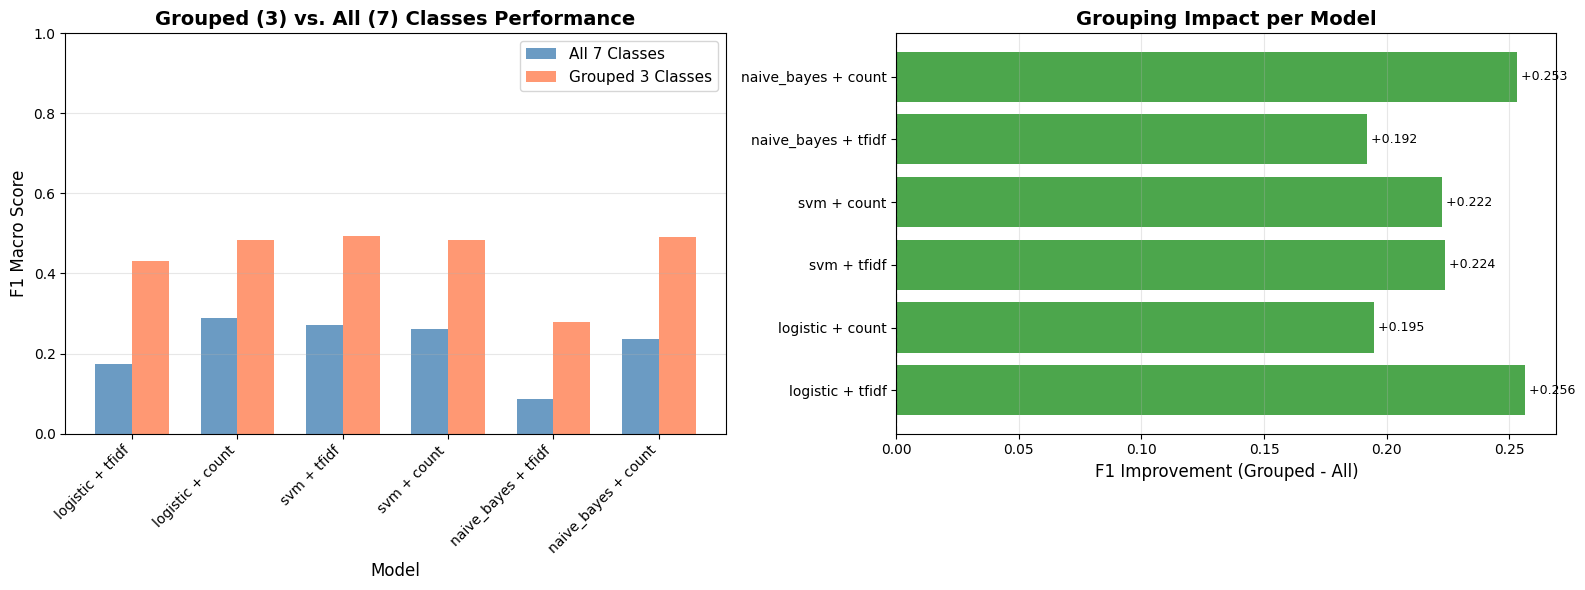


CONCLUSION
✓ Grouping classes IMPROVES performance on average by 0.2237 F1 points
  (101.7% relative improvement)

Best model for grouping: logistic + tfidf
  Improvement: +0.2563


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Side-by-side comparison
x = np.arange(len(df_comparison))
width = 0.35

axes[0].bar(x - width/2, df_comparison['f1_all_7'], width, 
            label='All 7 Classes', alpha=0.8, color='steelblue')
axes[0].bar(x + width/2, df_comparison['f1_grouped_3'], width, 
            label='Grouped 3 Classes', alpha=0.8, color='coral')

axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('F1 Macro Score', fontsize=12)
axes[0].set_title('Grouped (3) vs. All (7) Classes Performance', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_comparison['model'], rotation=45, ha='right', fontsize=10)
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0, 1.0)

# Right plot: Improvement
colors = ['green' if x > 0 else 'red' for x in df_comparison['improvement']]
axes[1].barh(df_comparison['model'], df_comparison['improvement'], color=colors, alpha=0.7)
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1.5)
axes[1].set_xlabel('F1 Improvement (Grouped - All)', fontsize=12)
axes[1].set_title('Grouping Impact per Model', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Add value labels on improvement bars
for i, (idx, row) in enumerate(df_comparison.iterrows()):
    axes[1].text(row['improvement'], i, f" {row['improvement']:+.3f}", 
                va='center', fontsize=9)

plt.tight_layout()
plt.savefig('figures/phase3_grouped_vs_all_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("CONCLUSION")
print("="*80)
if avg_improvement > 0:
    print(f"✓ Grouping classes IMPROVES performance on average by {avg_improvement:.4f} F1 points")
    print(f"  ({avg_improvement/df_comparison['f1_all_7'].mean()*100:.1f}% relative improvement)")
else:
    print(f"✗ Grouping classes DECREASES performance on average by {abs(avg_improvement):.4f} F1 points")
    print(f"  ({abs(avg_improvement)/df_comparison['f1_all_7'].mean()*100:.1f}% relative decrease)")

best_grouped = df_comparison['improvement'].idxmax()
print(f"\nBest model for grouping: {df_comparison.loc[best_grouped, 'model']}")
print(f"  Improvement: {df_comparison.loc[best_grouped, 'improvement']:+.4f}")

## Overall Best Model with Detailed Metrics


OVERALL BEST MODEL FOR EVASION DETECTION
Classifier:   svm
Vectorizer:   tfidf
Classes:      grouped_3
Meta Features: True

Performance:
  F1 Macro:     0.4941
  F1 Weighted:  0.5782
  Precision:    0.5465
  Recall:       0.4737
  Accuracy:     0.5971


<Figure size 1000x800 with 0 Axes>

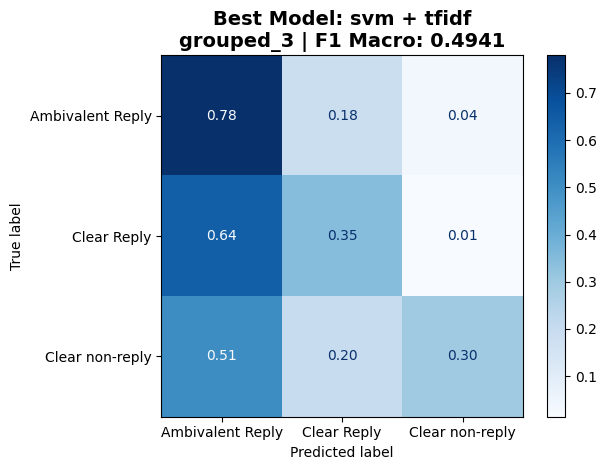

In [11]:
# Combine all results
all_results = pd.concat([df_all_classes, df_grouped])
all_results_sorted = all_results.sort_values('f1_macro', ascending=False)

best_overall = all_results_sorted.iloc[0]

print("\n" + "="*80)
print("OVERALL BEST MODEL FOR EVASION DETECTION")
print("="*80)
print(f"Classifier:   {best_overall['classifier']}")
print(f"Vectorizer:   {best_overall['vectorizer']}")
print(f"Classes:      {best_overall['classes']}")
print(f"Meta Features: {best_overall['use_meta']}")
print(f"\nPerformance:")
print(f"  F1 Macro:     {best_overall['f1_macro']:.4f}")
print(f"  F1 Weighted:  {best_overall['f1_weighted']:.4f}")
print(f"  Precision:    {best_overall['precision']:.4f}")
print(f"  Recall:       {best_overall['recall']:.4f}")
print(f"  Accuracy:     {best_overall['accuracy']:.4f}")

# Train best model and show confusion matrix
use_grouped = (best_overall['classes'] == 'grouped_3')
_, best_pipeline, y_pred, y_true = run_classifier_experiment(
    clf_name=best_overall['classifier'],
    vectorizer_name=best_overall['vectorizer'],
    use_grouped=use_grouped,
    train_df=train_df,
    val_df=val_df,
    use_meta_features=True
)

# Plot confusion matrix
labels = sorted(y_true.unique())
cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='.2f')
plt.title(f"Best Model: {best_overall['classifier']} + {best_overall['vectorizer']}\n"
          f"{best_overall['classes']} | F1 Macro: {best_overall['f1_macro']:.4f}",
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/phase3_best_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## Classifier Comparison Visualization

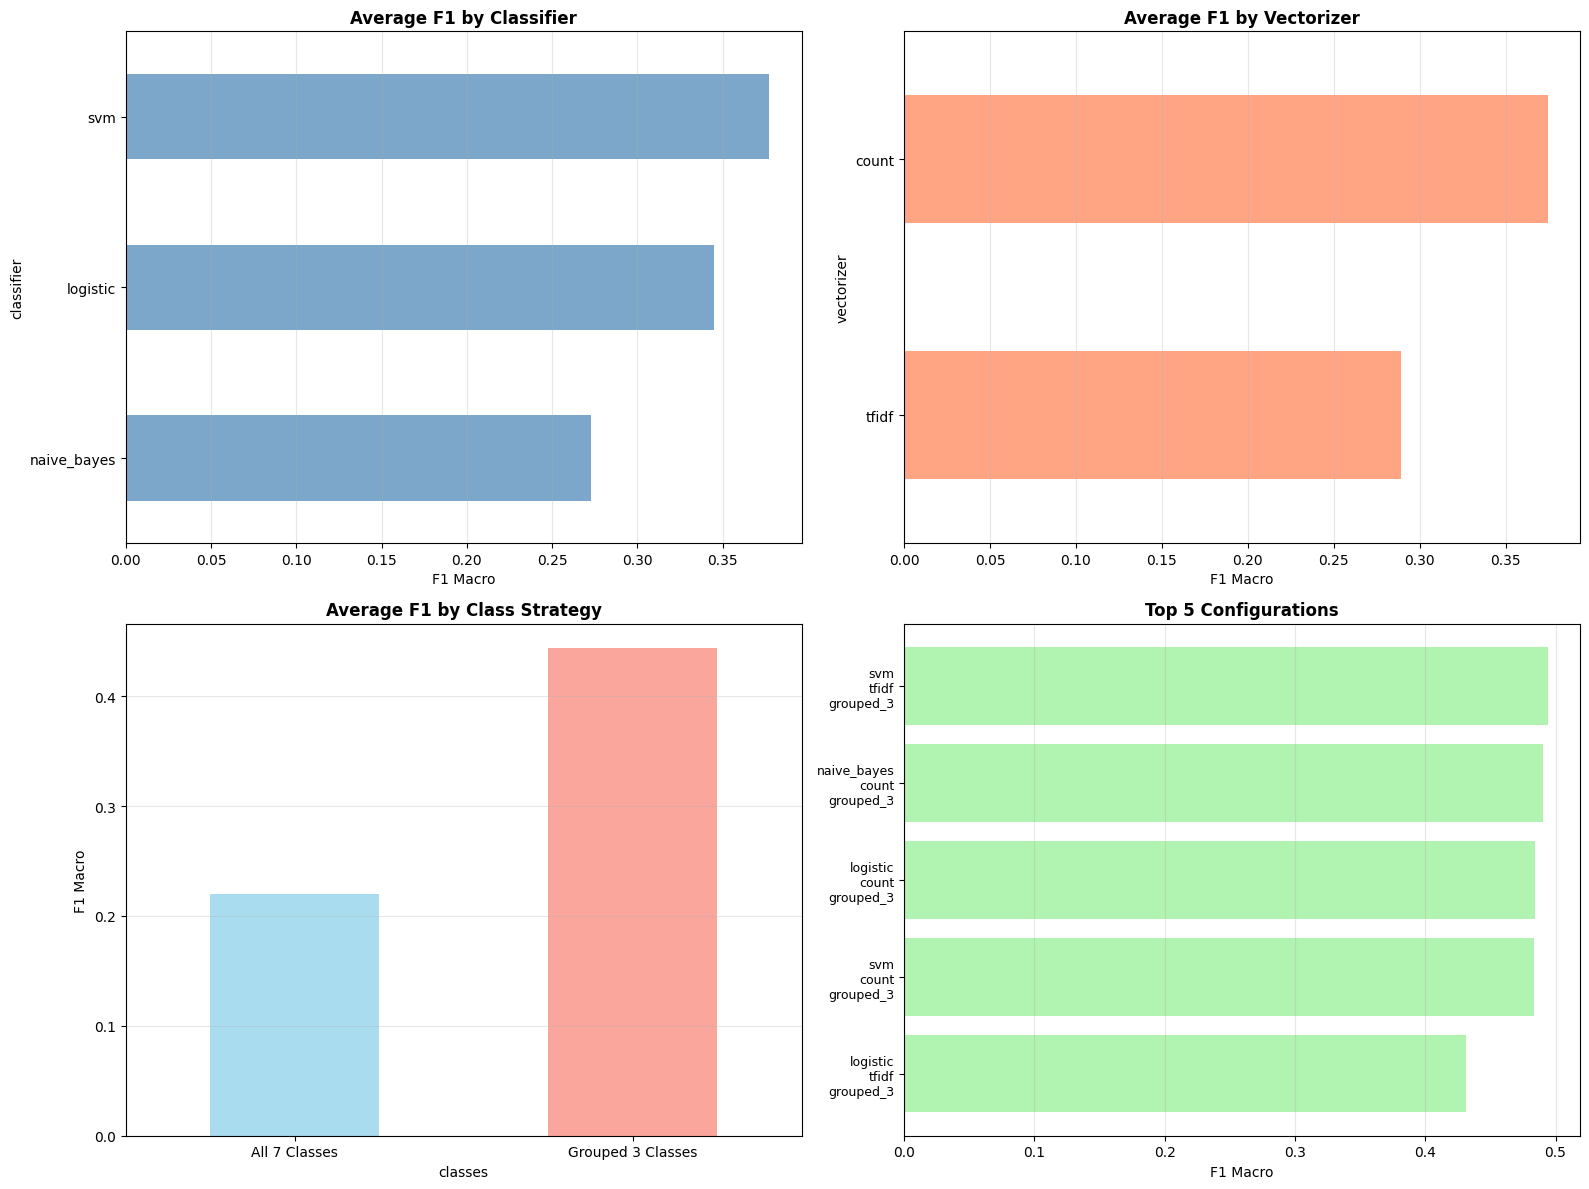

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# By classifier
clf_comparison = all_results.groupby('classifier')['f1_macro'].mean().sort_values()
clf_comparison.plot(kind='barh', ax=axes[0, 0], color='steelblue', alpha=0.7)
axes[0, 0].set_title('Average F1 by Classifier', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('F1 Macro')
axes[0, 0].grid(axis='x', alpha=0.3)

# By vectorizer
vec_comparison = all_results.groupby('vectorizer')['f1_macro'].mean().sort_values()
vec_comparison.plot(kind='barh', ax=axes[0, 1], color='coral', alpha=0.7)
axes[0, 1].set_title('Average F1 by Vectorizer', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('F1 Macro')
axes[0, 1].grid(axis='x', alpha=0.3)

# By class strategy
class_comparison = all_results.groupby('classes')['f1_macro'].mean()
class_comparison.plot(kind='bar', ax=axes[1, 0], color=['skyblue', 'salmon'], alpha=0.7)
axes[1, 0].set_title('Average F1 by Class Strategy', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('F1 Macro')
axes[1, 0].set_xticklabels(['All 7 Classes', 'Grouped 3 Classes'], rotation=0)
axes[1, 0].grid(axis='y', alpha=0.3)

# Overall ranking
top_5 = all_results_sorted.head(5)
top_5_labels = [f"{row['classifier']}\n{row['vectorizer']}\n{row['classes']}" 
                for _, row in top_5.iterrows()]
axes[1, 1].barh(range(len(top_5)), top_5['f1_macro'], color='lightgreen', alpha=0.7)
axes[1, 1].set_yticks(range(len(top_5)))
axes[1, 1].set_yticklabels(top_5_labels, fontsize=9)
axes[1, 1].set_title('Top 5 Configurations', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('F1 Macro')
axes[1, 1].grid(axis='x', alpha=0.3)
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('figures/phase3_overall_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Export Results

In [ ]:
# # Save all results to CSV
# df_all_classes.to_csv('results/phase3_all_7_classes.csv', index=False)
# df_grouped.to_csv('results/phase3_grouped_3_classes.csv', index=False)
# df_comparison.to_csv('results/phase3_comparison_grouped_vs_all.csv', index=False)
# all_results_sorted.to_csv('results/phase3_all_results.csv', index=False)

# # Save best model info
# with open('results/phase3_best_model.txt', 'w') as f:
#     f.write("BEST MODEL FOR EVASION DETECTION\n")
#     f.write("="*50 + "\n\n")
#     f.write(f"Classifier:    {best_overall['classifier']}\n")
#     f.write(f"Vectorizer:    {best_overall['vectorizer']}\n")
#     f.write(f"Classes:       {best_overall['classes']}\n")
#     f.write(f"Meta Features: {best_overall['use_meta']}\n")
#     f.write(f"\nPerformance:\n")
#     f.write(f"  F1 Macro:    {best_overall['f1_macro']:.4f}\n")
#     f.write(f"  F1 Weighted: {best_overall['f1_weighted']:.4f}\n")
#     f.write(f"  Precision:   {best_overall['precision']:.4f}\n")
#     f.write(f"  Recall:      {best_overall['recall']:.4f}\n")
#     f.write(f"  Accuracy:    {best_overall['accuracy']:.4f}\n")

# print("\n" + "="*80)
# print("Results exported to results/ directory")
# print("Figures saved to figures/ directory")
# print("\nPhase 3 complete! ✓")
# print("="*80)